<a href="https://colab.research.google.com/github/Ji-Sung05/Front-end_NAV_BAR/blob/master/CNN_transfer_learning_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기

Saving trash.zip to trash.zip


In [ ]:
!unzip trash.zip -d trash/

Archive:  trash.zip
   creating: trash/test/cardboard/
  inflating: trash/test/cardboard/cardboard100.jpg  
  inflating: trash/test/cardboard/cardboard105.jpg  
  inflating: trash/test/cardboard/cardboard108.jpg  
  inflating: trash/test/cardboard/cardboard111.jpg  
  inflating: trash/test/cardboard/cardboard112.jpg  
  inflating: trash/test/cardboard/cardboard115.jpg  
  inflating: trash/test/cardboard/cardboard116.jpg  
  inflating: trash/test/cardboard/cardboard119.jpg  
  inflating: trash/test/cardboard/cardboard12.jpg  
  inflating: trash/test/cardboard/cardboard120.jpg  
  inflating: trash/test/cardboard/cardboard123.jpg  
  inflating: trash/test/cardboard/cardboard124.jpg  
  inflating: trash/test/cardboard/cardboard127.jpg  
  inflating: trash/test/cardboard/cardboard128.jpg  
  inflating: trash/test/cardboard/cardboard131.jpg  
  inflating: trash/test/cardboard/cardboard132.jpg  
  inflating: trash/test/cardboard/cardboard135.jpg  
  inflating: trash/test/cardboard/cardboard13

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset 구축

In [ ]:
# train daatset
data_path = 'trash/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=2,
    shuffle=True
)

print(len(train_dataset))

1030


In [ ]:
# test dataset
test_path = 'trash/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

463


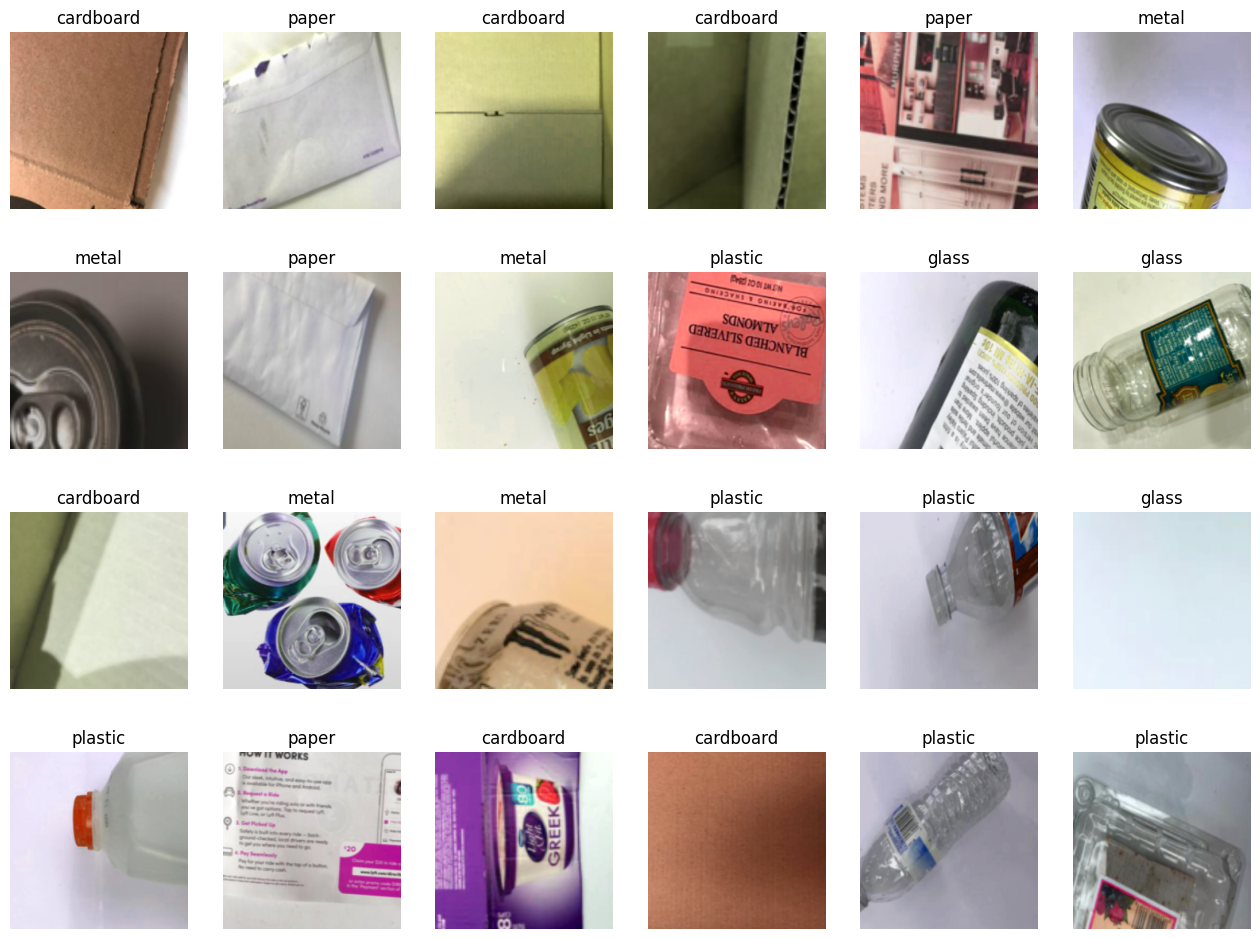

In [ ]:
# check dataset
samples, labels = next(iter(train_loader))
classes = {0:'cardboard', 1: 'glass', 2:'metal', 3:'paper', 4:'plastic'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## 전이 학습을 위한 코드 추가

In [ ]:
# 모델 변경 가능
resnet34 = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 86.8MB/s]


torchvision.models.resnet34을 불러와 ResNet34 아키텍처를 불러온다.
이때, pretrained=True로 설정하여, 사전 학습된 파라미터 값을 불러올 수 있도록 설정.

In [ ]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# ResNet34 모델의 일부 레이어에 대해 gradient 값을 변경한다.
set_parameter_requires_grad(resnet34)

이전에 학습된 ResNet34 모델의 일부 레이어들은 이미 학습이 완료되어 있으므로, ResNet34 모델의 일부 레이어들의 gradient 값을 유지시키기 위해, 해당 레이어들의 문제에 적용할 경우, 이전에 학습된 모델의 특징 추출 능력을 최대한 활용하기 위해 이전의 레이어들은 freeze 하고, 새롭게 추가된 레이어들은 아직 학습되어야 하므로 requires_grad값을 True로 설정하여 학습이 가능하도록 해야 한다.

In [ ]:
resnet34.fc = nn.Linear(512, 5)

In [ ]:
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 5)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TL-update parameter
params_to_update = []
for name,param in resnet34.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


# FashionCNN 모델 구축

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=16*14*14, out_features=512)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.drop(out)
        out = self.fc3(out)
        out = self.drop(out)
        out = self.fc4(out)
        return out

# Training and Test

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=100, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('trash/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [ ]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('trash/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [ ]:
# 전이 학습 training
TL_train_acc_hist, TL_train_loss_hist = train_model(resnet34, train_loader, criterion, optimizer, device)

# 전이 학습 test
TL_val_acc_hist = eval_model(resnet34, test_loader, device)

Epoch 0/99
----------
Loss: 1.3723 Acc: 0.4369

Epoch 1/99
----------
Loss: 0.9763 Acc: 0.6583

Epoch 2/99
----------
Loss: 0.8045 Acc: 0.7427

Epoch 3/99
----------
Loss: 0.7085 Acc: 0.7621

Epoch 4/99
----------
Loss: 0.6962 Acc: 0.7553

Epoch 5/99
----------
Loss: 0.6325 Acc: 0.7767

Epoch 6/99
----------
Loss: 0.6063 Acc: 0.7913

Epoch 7/99
----------
Loss: 0.5903 Acc: 0.7893

Epoch 8/99
----------
Loss: 0.5431 Acc: 0.7942

Epoch 9/99
----------
Loss: 0.5545 Acc: 0.8039

Epoch 10/99
----------
Loss: 0.5151 Acc: 0.8262

Epoch 11/99
----------
Loss: 0.5097 Acc: 0.8301

Epoch 12/99
----------
Loss: 0.5118 Acc: 0.8252

Epoch 13/99
----------
Loss: 0.4784 Acc: 0.8417

Epoch 14/99
----------
Loss: 0.4691 Acc: 0.8291

Epoch 15/99
----------
Loss: 0.4553 Acc: 0.8437

Epoch 16/99
----------
Loss: 0.4626 Acc: 0.8417

Epoch 17/99
----------
Loss: 0.4627 Acc: 0.8359

Epoch 18/99
----------
Loss: 0.4846 Acc: 0.8320

Epoch 19/99
----------
Loss: 0.4569 Acc: 0.8301

Epoch 20/99
----------
Loss: 0

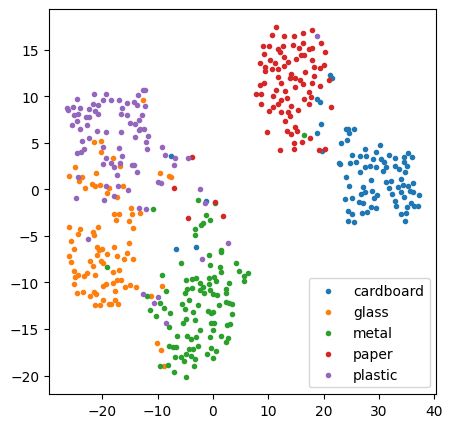

In [ ]:
# 전이 학습 TSNE
actual = []
deep_features = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = resnet34(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
for i, label in zip(range(5), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

In [ ]:
# CNN-update parameter

learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Ba

In [ ]:
# CNN training
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

# CNN test
val_acc_hist = eval_model(model, test_loader, device)

Epoch 0/99
----------
Loss: 1.7270 Acc: 0.3495

Epoch 1/99
----------
Loss: 1.3837 Acc: 0.4272

Epoch 2/99
----------
Loss: 1.3817 Acc: 0.4087

Epoch 3/99
----------
Loss: 1.3359 Acc: 0.4417

Epoch 4/99
----------
Loss: 1.3288 Acc: 0.4796

Epoch 5/99
----------
Loss: 1.2536 Acc: 0.4981

Epoch 6/99
----------
Loss: 1.2253 Acc: 0.5029

Epoch 7/99
----------
Loss: 1.2287 Acc: 0.4971

Epoch 8/99
----------
Loss: 1.1659 Acc: 0.5233

Epoch 9/99
----------
Loss: 1.1486 Acc: 0.5291

Epoch 10/99
----------
Loss: 1.1194 Acc: 0.5650

Epoch 11/99
----------
Loss: 1.1496 Acc: 0.5291

Epoch 12/99
----------
Loss: 1.0923 Acc: 0.5709

Epoch 13/99
----------
Loss: 1.1283 Acc: 0.5408

Epoch 14/99
----------
Loss: 1.1298 Acc: 0.5456

Epoch 15/99
----------
Loss: 1.0687 Acc: 0.5903

Epoch 16/99
----------
Loss: 1.0166 Acc: 0.6146

Epoch 17/99
----------
Loss: 1.0327 Acc: 0.6010

Epoch 18/99
----------
Loss: 1.0451 Acc: 0.5845

Epoch 19/99
----------
Loss: 1.0991 Acc: 0.5670

Epoch 20/99
----------
Loss: 1

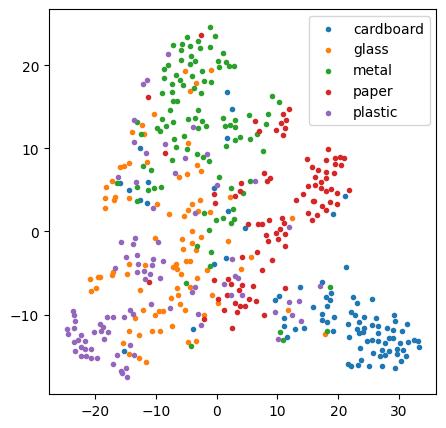

In [ ]:
# CNN TSNE
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
for i, label in zip(range(5), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

# 전이 학습 vs CNN

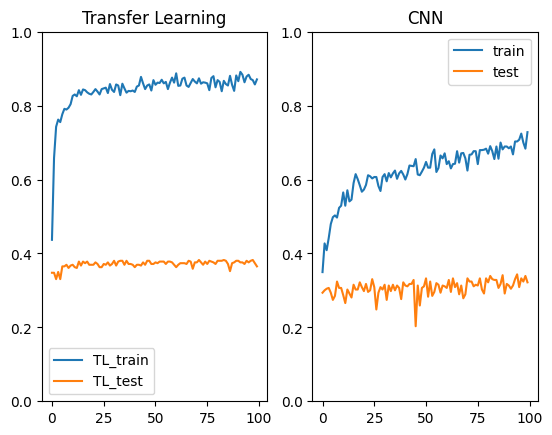

In [ ]:
# plt.plot(train_acc_hist)
# plt.plot(val_acc_hist)
# plt.show()

plt.subplot(121)
plt.plot(TL_train_acc_hist, label="TL_train")
plt.plot(TL_val_acc_hist, label="TL_test")
#plt.xlim([0, 4])
plt.ylim([0, 1])
plt.legend()
plt.title("Transfer Learning")

plt.subplot(122)
plt.plot(train_acc_hist, label="train")
plt.plot(val_acc_hist, label="test")
#plt.xlim([0, 4])
plt.ylim([0, 1])
plt.legend()
plt.title("CNN")

plt.show()

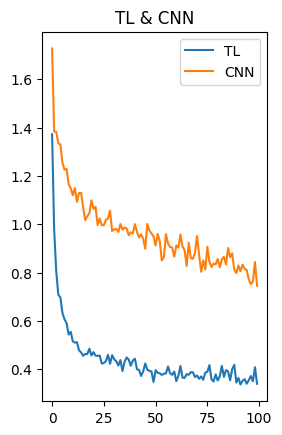

In [ ]:
plt.subplot(121)
plt.plot(TL_train_loss_hist, label="TL")
plt.plot(train_loss_hist, label="CNN")
# plt.xlim([0, 4])
# plt.ylim([0, 1])
plt.legend()
plt.title("TL & CNN")

plt.show()